# Stock Price Predictor - Data Preparation

## Notebook Overview
- [1. Load Modules and Data](#load-data)
- [2. Model Descriptions](#model-descriptions)
    - [2.1 ARIMA Model](#ARIMA-Model)
    - [2.2 DeepAR Model](#DeepAR-Model)
- [3. Multiple Time Series](#multiple-time-series)
- [4. Split Data](#split-data)
    - [4.1 ARIMA Model](#split-arima-model)
    - [4.2 DeepAR Model](#split-deepar-model)
- [5. Saving Data](#save-in-json-format)
    - [5.1 ARIMA Model](#save-arima-model)
    - [5.2 DeepAR Model](#save-deepar-model)

## Plan of Action
The aim of this notebook is to prepare train and test data, and save it as a `CSV` or `JSON` file. First any data processing will be carried out. Then data will be split into train and test data as required by respective models. 

> *Note: ideally, data is split into training and test data, and then **separately** processed. However, as this is time series data, where the train-test split cannot be randomly selected points, processing first should not affect (leak) the results in any way.

The goal is to save data in a format that can be easily read by the models in the next notebook. Additionally, the project is to be focused on training a model than can predict the price of the stock for the first `10 months` of 2020. 

> In this section, data will be divided to train and test data for each of the two models.

<a id="load-data"></a>
# 1. Load Modules and Data
All the required modules will be loaded here along with the data from the `CSV` files in the `data` directory files.

> **Citation for data**: _Yahoo Finance – stock market live, quotes, business &amp; finance news_ (no date). Available at: https://in.finance.yahoo.com/ (Accessed: 2 October 2020).

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

pd.set_option('display.max_rows', None)
timezone_str = 'Asia/Kolkata'
localtz = pytz.timezone(timezone_str)

In [2]:
# Load stocks data
stock_names = {'^GSPC': 'S&P 500',
               '^BSESN': 'S&P BSE SENSEX',
               'AAPL': 'Apple Inc.'}

data_dir = 'data'
data = {}

for stock in stock_names.keys():
    data[stock] = pd.read_csv(os.path.join(data_dir, stock + '.csv'),
                              parse_dates=True, index_col=['Date'])
    data[stock] = data[stock].dropna()

In [3]:
data['AAPL'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


> **_NOTE: The folowing sections will consider only `AAPL` stock data. Later, similar steps will be carried out on the two indices: `^GSPC` and `^BSESN`_**

<a id="model-descriptions"></a>
# 2. Model Descriptions
In this section, I will give a description of the models. We will discuss model types and how the models take data and process it. There are two models that will be used to make predictions and the results from both will later be compared.

<a id="ARIMA-Model"></a>
## 2.1 ARIMA Model
One of the major problems with time series problems are the non-stationary nature of most time series. To get around this obstacle, a time series is usually stationaized. This is done by reducing effects of trends and seasonality, training a model and finally converting the predicitons back (adding trends and seasonality). A complex method can be used to efficiently stationarize a time series, but it makes it harder to convert the results back. Though differencing is not the most efficient of stationarizing a time series, it provides an easy to remove and add trends and seasonality. Hence, ARIMA model is chosen for this project.

ARIMA (Auto-Regressive Integrated Moving Average) utilizes differencing to stationarize a non-stationary time series. It takes in three parameters:
1. Number of `auto-regressive terms` (p): The number of past terms, the current value depends on.
2. Number of `differences` (d): Difference between two consecutive terms if `d=1`, higher degree takes differences between more terms.
3. Number of `moving average terms` (q): The number of past error terms, the current value depends on.

Determining optimal values of `p` and `q` is part of modelling ARIMA. Two plots are used to determine these values.
1. Autocorrelation Function (ACF)
2. Partial Autocorrelation Function (PACF)

> **Source**: Brownlee, J. (2020) Probabilistic Model Selection with AIC, BIC, and MDL, Machine Learning Mastery. Available at: https://machinelearningmastery.com/probabilistic-model-selection-measures/ (Accessed: 30 October 2020).

An ARIMA model takes a single time series to train. Therefore, there is not much data processing required. The only thing that needs to be taken care of is missing `NaN` values. The data will be prepared here and the parameters `(p, d, q)` will be determined in the next notebook.

<a id="DeepAR-Model"></a>
## 2.2 DeepAR Model

DeepAR is Amazon SageMaker's supervised learning algorithm that uses a recurrent neural network (RNN) to train on the data provided. The neural network trains on multiple time series of predefined length. It uses a **context length** to predict adjacent "_prediction window_". A "_training example_" is of the same length and is made up of context and prediction lengths.

DeepAR accepts a `.json` file with training data. The format of the file is to be `JSON Lines`, with each like as follow (*source: AWS website*):
- `start` (str): timestamp of format `YYYY-MM-DD HH:MM:SS`.
- `target` (array of floats): values in the time series.
- `cat` (optional, integer): catergory for multivariate time series.

> **Source**: Amazon Web Services, I. (no date) DeepAR Forecasting Algorithm - Amazon SageMaker. Available at: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html (Accessed: 29 October 2020).

Another important point about missing data is to be taken into consideration. In one of DeepAR's update<sup>1</sup>, it is mentioned that it supports missing data points. However, after an multiple attempts to train a model and ending with the following error, it was evident that all the missing data can be **cannot** be included in the `target` array and as DeepAR is not able to parse data with `Nan`.

Error: `ClientError: Error when parsing json`

> <sup>1</sup>Flunkert, V. et al. (2018) Amazon SageMaker DeepAR now supports missing values, categorical and time series features, and generalized frequencies | AWS Machine Learning Blog, Amazon SageMaker, Artificial Intelligence. Available at: https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-deepar-now-supports-missing-values-categorical-and-time-series-features-and-generalized-frequencies/ (Accessed: 29 October 2020).

One way to deal with missing values in a time series problem is by interpolating the results. As `mean` cannot work and skipping values in a time series could have effects on the DeepAR algorithm that I am not aware of. Hence, for now, interpolation is used to fill in the gaps.

In [4]:
# Adding `NaN` for missing timestamp values.
df = data['AAPL'].index
idx = pd.date_range(min(df.date), max(df.date))
aapl_updated = data['AAPL'].copy().reindex(idx)

aapl_updated.head()

,Open,High,Low,Close,Adj Close,Volume
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1980-12-13,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-14,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0


In [5]:
# Interpolating
aapl_data = aapl_updated.copy().interpolate()
aapl_data.head()

,Open,High,Low,Close,Adj Close,Volume
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,4.690336e+08
1980-12-13,0.126302,0.126674,0.126116,0.126116,0.099500,3.713173e+08
1980-12-14,0.124256,0.124442,0.123884,0.123884,0.097739,2.736011e+08
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,1.758848e+08
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,1.057280e+08


In [6]:
aapl_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

As it can be seen above, we have no `NaN` values. Now let's create a function that can take a pandas series and split it into multiple smaller time series.

<a id="multiple-time-series"></a>
# 3. Create Multiple Time Series - DeepAR
The following function creates a list of time series. The DeepAR algorithm will use each to train a recurrent neural network.

In [7]:
def create_time_series(data: pd.Series, series_length_years: int, 
                       start_date: datetime.datetime = None,
                       last_date: datetime.datetime = None,
                       equal_series: bool = True):
    """Creates a list of time series of the given length from the data provided.
    Args:
        data (pd.Series): pandas series with all the data, indexed with the timestamp.
        series_length_years (int): length of each series in the list to be created.
        start_date (datetime.datetime, optional): 
            Date the first time series should start from. If None, '2002-01-01' is used.
            Defaults to None.
        last_date (datetime.datetime, optional):
            Date the last time series should end on. If None, last date found in `data` will be used.
            Defaults to None.
        equal_series (bool): if True, all series created will be of equal length. last series created
                             will be removed if it is shorter than the others.
    
    Returns:
        (list of pd.Series): python list containing all the time series created.
    
    """
    # Updating dictionaries.
    if start_date is None:
        start_date = datetime.datetime(2002, 1, 1)
    if last_date is None:
        last_date = max(data.index.date)
    else:
        last_date = last_date.date()
    
    start_date = start_date.date()
    time_series_list = []

    while start_date < last_date:
        end_date = start_date + pd.DateOffset(years=series_length_years) - pd.DateOffset(days=1)
        ts = data.loc[start_date:end_date]
        time_series_list.append(ts)
        print(f'Time series of length {len(ts)} created.')
        start_date = end_date + pd.DateOffset(days=1)
        
    is_last_equal = str(max(time_series_list[0].index.date))[5:10] == str(max(time_series_list[-1].index.date))[5:10]
    
    if equal_series and not is_last_equal:
        time_series_list = time_series_list[:-1]
    
    print(f'\n\nNumber of series created: {len(time_series_list)}')
    print(f'Last series removed: {not is_last_equal}')
    print(f'Last series end date: {max(time_series_list[-1].index.date)}')
    return time_series_list

To ensure each of the time series is of the same length, we should account of the leap years in all of them. Hence, a good number of years to have per time series is 4. Hence, a series length of `4 years` is chosen.

In [8]:
start = datetime.datetime(2000, 1, 1)

ts_list = create_time_series(aapl_data['Adj Close'], 4, start)

Time series of length 1461 created.
Time series of length 1461 created.
Time series of length 1461 created.
Time series of length 1461 created.
Time series of length 1461 created.
Time series of length 275 created.


Number of series created: 5
Last series removed: True
Last series end date: 2019-12-31


> A series length of 4 years and prediction length of 10 months, means that the train-test split is of about 80:20 ratio.

<a id="split-data"></a>
# 4. Split Data
The train-test split being created for DeepAR will contain multiple time series, while for the ARIMA model one large time series will be split into train and test dataset. If the Maintaining the prediction length for both the models, the data split percent will be quite differently. ARIMA model will be provided one a train series of around 218 months long and test time would include the last 10 months of 2019. Both the models will be tested on the first 10 months of 2020 (Jan 2020 - Oct 2020). This will ensure a more robust comparison between the two.

<a id="split-arima-model"></a>
## 4.1 ARIMA model
The data from years `2000` to `2019` will be split into train and test data. The prediction length is equal to `10 months`. Furthermore, the interpolated data (done for DeepAR) will be used.

In [9]:
start = datetime.datetime(2000, 1, 1)
end_test = datetime.datetime(2019, 12, 31)
end_train = end_test - pd.DateOffset(months=10)

arima_test = aapl_data['Adj Close'][start:end_test]
arima_train = aapl_data['Adj Close'][start:end_train]

print(f'Test ts date range:  {min(arima_test.index.date)} - {max(arima_test.index.date)}\n'
      f'Test Series length:  {len(arima_test)}\n'
      f'Train ts date range: {min(arima_train.index.date)} - {max(arima_train.index.date)}\n'
      f'Train Series length: {len(arima_train)}')

Test ts date range:  2000-01-01 - 2019-12-31
Test Series length:  7305
Train ts date range: 2000-01-01 - 2019-02-28
Train Series length: 6999


In [10]:
def plot_train_test_data(train_ts, test_ts, pred_ts=None):
    fig, ax = plt.subplots(figsize=(20,10))
    
    test_ts.plot(ax=ax,
                 color='green',
                 label='Test Series')
    train_ts.plot(ax=ax,
                  color='blue',
                  label='Train Series',
                  alpha=0.7)
    
    ax.set_title('Created Train and Test Time Series',
                 fontdict={'size': 20, 'weight': 'bold'})
    ax.set_xlabel('Timestamp', fontdict={"size": 14})
    ax.set_ylabel('Price ($)', fontdict={"size": 14})
    
    leg = ax.legend(fontsize=16, frameon=True, loc='best')
    leg.get_frame().set_color('#F2F2F2')
    leg.get_frame().set_edgecolor('black')
    leg.set_title("Legend", prop={"size": 20, "weight": 'bold'})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

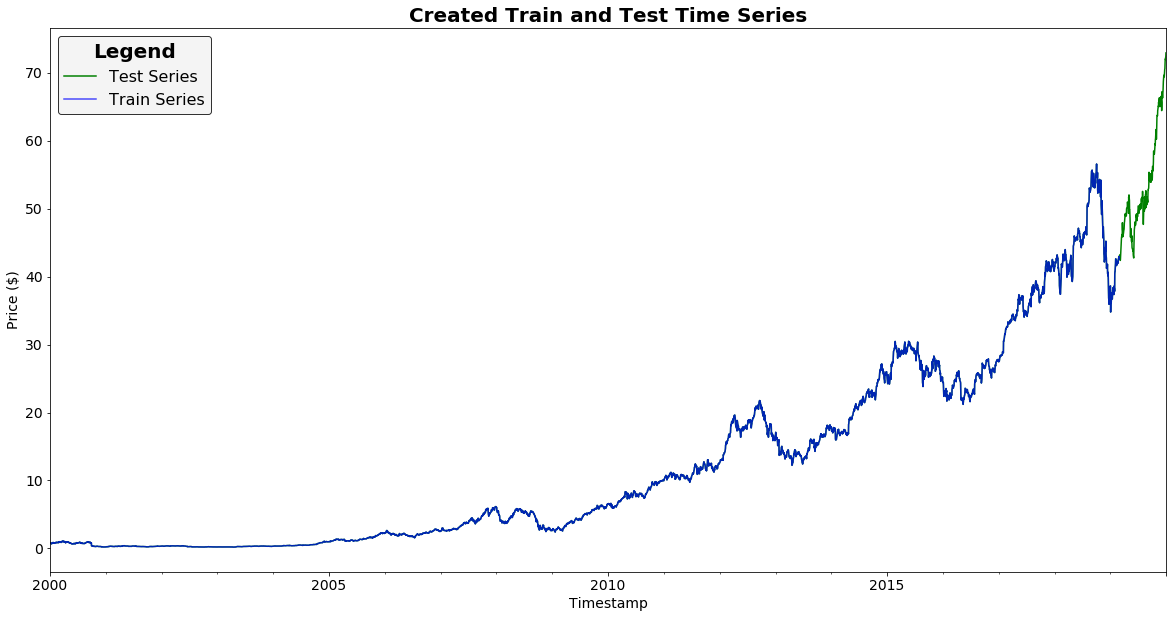

In [11]:
# Visual Representation of the data split.
plot_train_test_data(arima_train, arima_test)

<a id="split-deepar-model"></a>
## 4.2 DeepAR model
The following function takes a list of time series and prediction length and return a list of training time series.

In [12]:
def create_training_series(time_series_list: list,
                           prediction_length_months: int):
    """Create a training series using the prediction length provided in months.
    
    Args:
        time_series_list (list): list of pandas series each of equal length.
        prediciton_length_months (int): number of months a prediction is to be made. This will be
                                        used to created a training series, i.e. context length for
                                        DeepAR algorithm to train on.
    
    Returns:
        list of pd.Series: python list containing the training time series.
    """
    training_series_list = []
    
    for ts in time_series_list:
        end = max(ts.index.date) - pd.DateOffset(months=prediction_length_months)
        training_series_list.append(ts[:end])

    print(f'Number of series updated: {len(training_series_list)}')
    return training_series_list

In [13]:
# Create training series
prediction_length = 10
train_ts_list = create_training_series(ts_list, prediction_length)

Number of series updated: 5


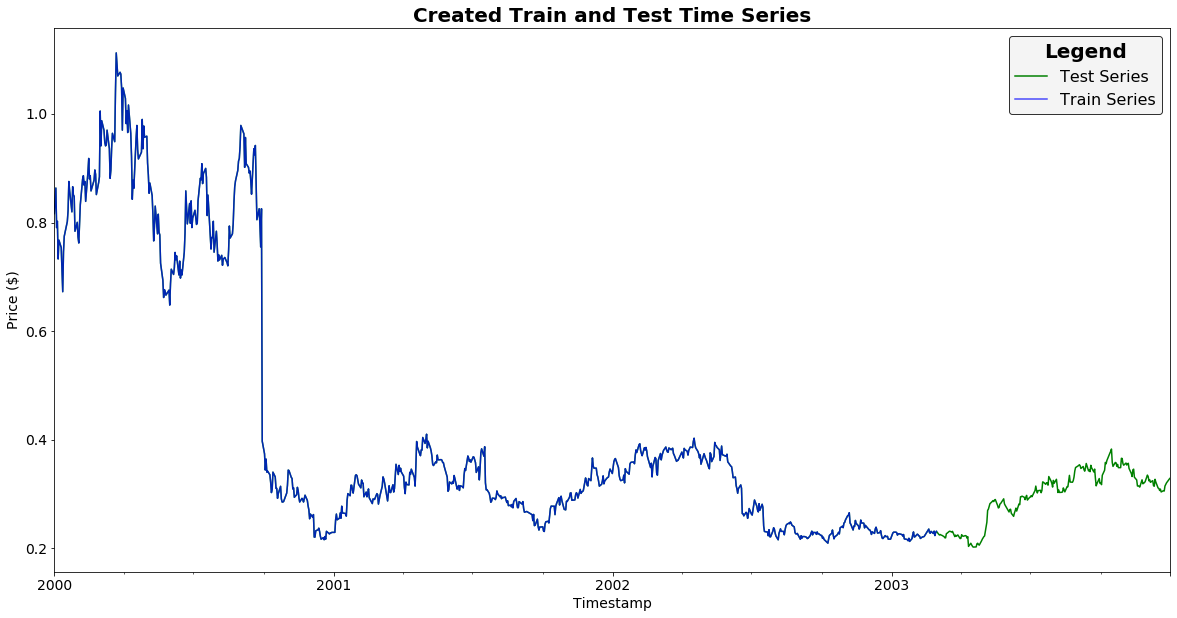

In [14]:
plot_train_test_data(train_ts_list[0], ts_list[0])

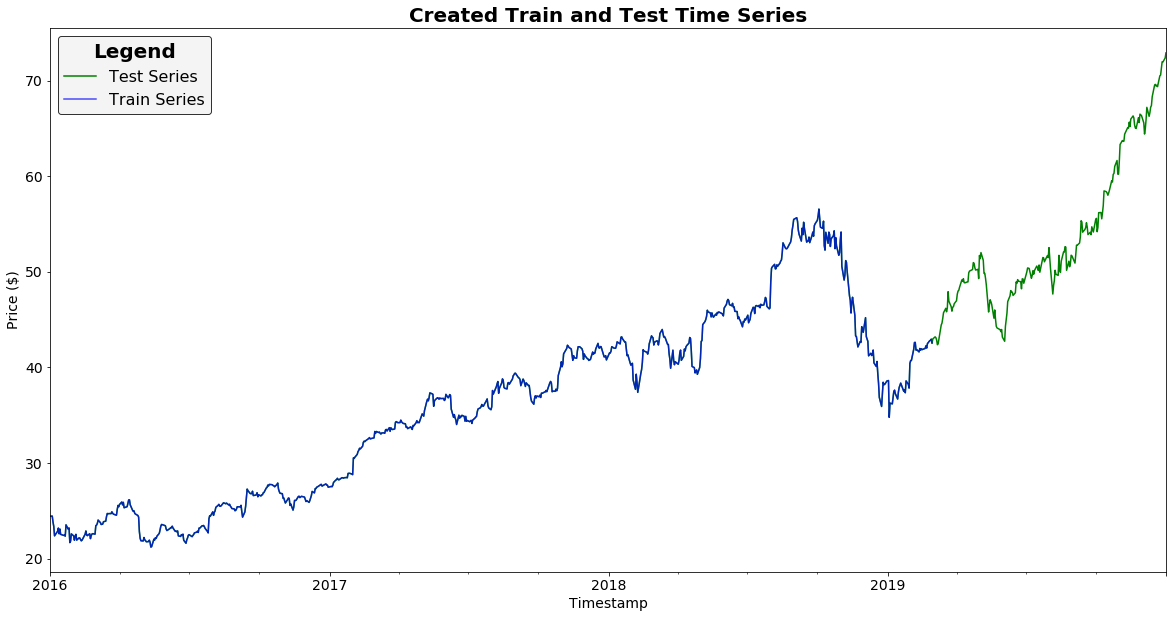

In [15]:
plot_train_test_data(train_ts_list[-1], ts_list[-1])

<a id="save-in-json-format"></a>
# 5. Saving Data
To access data in the other notebook and to upload data to a S3 bucket it needs to be saved locally. This is what is done in this section.

<a id="save-arima-model"></a>
## 5.1 ARIMA Model
The train and test data will be saved to a csv file for the ARIMA model as there is no particular format the algorith accepts the data in.

In [16]:
csv_data_dir = 'data/csv_aapl_data'

if not os.path.exists(csv_data_dir):
    os.makedirs(csv_data_dir)
    
arima_train.to_csv(os.path.join(csv_data_dir, f'train.csv'))
arima_test.to_csv(os.path.join(csv_data_dir, f'test.csv'))

print(f'Created {csv_data_dir} with train-test data.')

Created data/csv_aapl_data with train-test data.


<a id="save-deepar-model"></a>
## 5.2 DeepAR Model
Amazon SageMaker's DeepAR model accepts data in through a JSON file. The following function will create a `JSON Line` file for the list of time series input.

In [17]:
def save_series_to_json(time_series_list: list,
                        filename: str,
                        data_dir: str = 'json_time_series_data'):
    """Function takes a list of time series data and then saves in DeepAR, JSON format.
    
    Args:
        time_series_list (list): list of pandas series each of equal length.
        filename (str): name of the file that will contain the data in DeepAR, JSON format.
        data_dir (str, optional): name of directory that will hold the JSON files.
    
    Returns:
        str: path to the file created.
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    file_path = os.path.join(data_dir, filename)
    
    with open(file_path, 'wb') as f:
        for ts in time_series_list:
            line = json.dumps({
                "start": str(ts.index[0]),
                "target": ts.interpolate().dropna().tolist()}) + '\n'
            json_line = line.encode('utf-8')
            f.write(json_line)
    print(f'{file_path} created.')

In [18]:
json_data_dir = 'data/json_aapl_data'

train_data = save_series_to_json(train_ts_list, 'train.json', json_data_dir)
test_data = save_series_to_json(ts_list, 'test.json', json_data_dir)

data/json_aapl_data/train.json created.
data/json_aapl_data/test.json created.


> **Now that all the data is saved and ready to be used by the models, let's get to the final part of the project.**